## Logistic Regression

Logistic Regression is very similar to linear regression, except all of the points can only have $y$-values of $1$ or $0$. This is useful if we want to predict whether something is or isn't part of a particular class. Instead of fitting a line (as in linear regression), logistic regression involves fitting a probability curve.

For example, using our device traffic, let's see whether we can predict a DNS packet is request or response from its length. 

First, let's import the data, extract only the DNS packets, and view the first few packets.

In [1]:
# Pandas, Numpy
import numpy as np
import pandas as pd

# Machine Learning
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

# Plotting
import matplotlib.pyplot as plt
%matplotlib inline

# Libraries for Processing Network Traffic
import ipaddress
import netaddr
from data_collection.parse_pcap import pcap_to_pandas, pcap_to_dict

In [2]:
pcap = pcap_to_pandas('example_pcaps/google_home.pcap') # this can take a few minutes

# Pandas Dataframe with only DNS packets
dns_packets = pcap.loc[pcap['is_dns'] == True];
dns_packets.head(n=5)

,datetime,dns_query,dns_resp,ip_dst,ip_dst_int,ip_src,ip_src_int,is_dns,length,mac_dst,mac_dst_int,mac_src,mac_src_int,port_dst,port_src,protocol,time,time_normed
16,2017-12-07 14:48:44.399009,b'clients1.google.com.',None,8.8.8.8,1.347441e+08,172.24.1.51,2.887254e+09,True,79,b8:27:eb:2d:24:15,202481588839445,a4:77:33:2f:e0:6e,180831866839150,53.0,43659.0,UDP,1.512680e+09,3.242926
17,2017-12-07 14:48:44.419893,b'pool.ntp.org.',None,8.8.8.8,1.347441e+08,172.24.1.51,2.887254e+09,True,72,b8:27:eb:2d:24:15,202481588839445,a4:77:33:2f:e0:6e,180831866839150,53.0,37402.0,UDP,1.512680e+09,3.263810
18,2017-12-07 14:48:44.423984,b'clients1.google.com.',b'clients1.google.com.',172.24.1.51,2.887254e+09,8.8.8.8,1.347441e+08,True,119,a4:77:33:2f:e0:6e,180831866839150,b8:27:eb:2d:24:15,202481588839445,43659.0,53.0,UDP,1.512680e+09,3.267901
23,2017-12-07 14:48:44.458457,b'pool.ntp.org.',b'pool.ntp.org.',172.24.1.51,2.887254e+09,8.8.8.8,1.347441e+08,True,136,a4:77:33:2f:e0:6e,180831866839150,b8:27:eb:2d:24:15,202481588839445,37402.0,53.0,UDP,1.512680e+09,3.302374
27,2017-12-07 14:48:44.480588,b'_googlecast._tcp.local.',None,224.0.0.251,3.758097e+09,172.24.1.51,2.887254e+09,True,82,01:00:5e:00:00:fb,1101088686331,a4:77:33:2f:e0:6e,180831866839150,5353.0,5353.0,UDP,1.512680e+09,3.324505


Each row in the printed data is a packet and each column is a feature of the packet.

Next let's divide the DNS packets into requests and repsonses, and convert them into points where the $x$-value is the length of the packet and $y$-value is $0$ for requests and $1$ for responses. This will allow us to fit the data to a logistic regression curve.

In [3]:
dns_ft = dns_packets.loc[:,['length','dns_resp']]
dns_ft.head(10)

,length,dns_resp
16,79,None
17,72,None
18,119,b'clients1.google.com.'
23,136,b'pool.ntp.org.'
27,82,None
33,390,b'Google-Home-de204bc3dc23ad2c371dacfd3019540a...
34,250,b'de204bc3-dc23-ad2c-371d-acfd3019540a._google...
35,75,None
36,91,b'www.gstatic.com.'
44,390,b'Google-Home-de204bc3dc23ad2c371dacfd3019540a...


Let's see how many data points we have.

In [4]:
dns_ft.shape

(1361, 2)

Next we will convert the DNS response column into a 0/1 value so that it is amenable to logstic regression.

In [5]:
dns_ft['response'] = dns_ft['dns_resp'].astype(bool)
dns_ft['response'] = dns_ft['response'].astype(int)
dns_ft.head(10)

,length,dns_resp,response
16,79,None,0
17,72,None,0
18,119,b'clients1.google.com.',1
23,136,b'pool.ntp.org.',1
27,82,None,0
33,390,b'Google-Home-de204bc3dc23ad2c371dacfd3019540a...,1
34,250,b'de204bc3-dc23-ad2c-371d-acfd3019540a._google...,1
35,75,None,0
36,91,b'www.gstatic.com.',1
44,390,b'Google-Home-de204bc3dc23ad2c371dacfd3019540a...,1


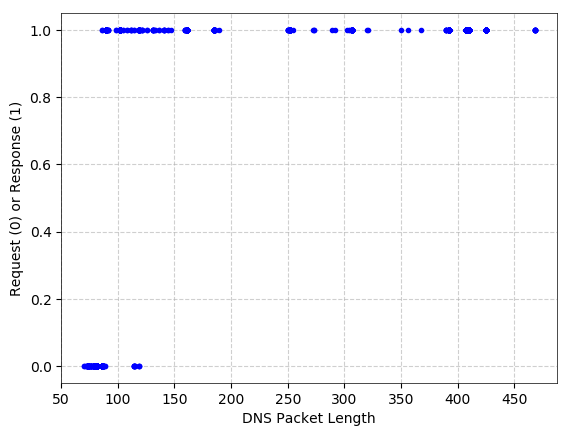

In [6]:
x = dns_ft['length'].values
y = dns_ft['response'].values

plt.plot(x,y, '.', color='blue')
plt.ylabel("Request (0) or Response (1)")
plt.xlabel("DNS Packet Length")
plt.grid(linestyle='--', alpha=0.6)
plt.show()

In [31]:
regr = LogisticRegression(solver='lbfgs', C=1)
regr.fit(x.reshape(-1,1),y)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

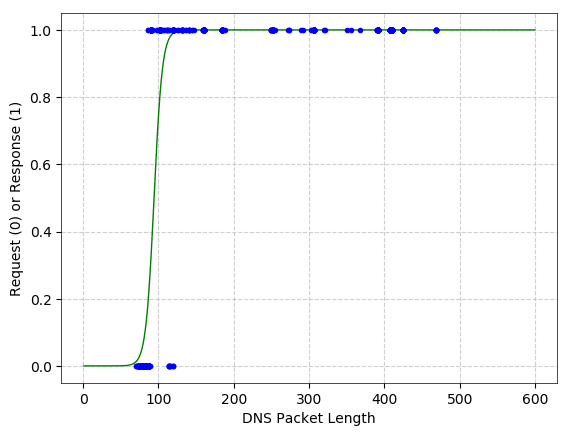

In [32]:
# Plot data
# z is a simple number line 1 to 600
z = np.arange(1, 600, 0.5).reshape(-1, 1);

# prediction: plot the number line against the predictions for those values
plt.plot(z, regr.predict_proba(z)[:, 1], color='green');
plt.plot(x,y, '.', color='blue')
plt.ylabel("Request (0) or Response (1)")
plt.xlabel("DNS Packet Length")
plt.grid(linestyle='--', alpha=0.6)
plt.show()

## Model Selection/Cross Validation

How do we know we have a good model? How do we know that the machine learning algorithm is "good"?

We can perform a K-fold cross-validaion on the data: 
* holding out 1/K of the data for testing, 
* training on the reamining data, 
* repeating this K times, one for each fold
* averaging the resulting accuracy/score of the model

In [33]:
from sklearn.model_selection import KFold, cross_val_score

kf = KFold(n_splits=5)

cv_results = cross_val_score(regr,
                             x.reshape(-1,1),
                             y,
                             cv=kf,
                             scoring="accuracy")

In [34]:
cv_results

array([0.98168498, 0.97426471, 0.97794118, 0.94485294, 0.92279412])

In [35]:
cv_results.mean()

0.9603075845722906

### Hyper-Parameter Tuning: Grid Search

Grid search can allow for hyper-parameter tuning, with cross validation, such as a the k-fold cross validation that we just performed.  The search performs the evaluation above, automating the search through the set of all possible parameters dedined in the grid.

The resulting model is returned as a result, and a model can be generated from the training data by calling `fit` on the results of the search.

In [38]:
from sklearn.model_selection import GridSearchCV

k = 5
C_range = np.arange(1,5,1)
params = {
    'C': C_range,
}

grid_model = GridSearchCV(estimator=regr,
                          param_grid=params,
                          cv=k,
                          return_train_score=True,
                          scoring='accuracy',
                          iid=True
                        )

grid_model_result = grid_model.fit(x.reshape(-1,1),y)

In [39]:
cv_results = pd.DataFrame(grid_model.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.008908,0.001616,0.000268,0.000053,1,{'C': 1},0.981685,0.974359,0.981685,0.948339,...,0.960323,0.025649,1,0.954963,0.956801,0.954963,0.963303,0.97156,0.960318,0.006403
1,0.008853,0.001480,0.000275,0.000062,2,{'C': 2},0.981685,0.974359,0.981685,0.948339,...,0.960323,0.025649,1,0.954963,0.956801,0.954963,0.963303,0.97156,0.960318,0.006403
2,0.008868,0.000953,0.000296,0.000081,3,{'C': 3},0.981685,0.974359,0.981685,0.948339,...,0.960323,0.025649,1,0.954963,0.956801,0.954963,0.963303,0.97156,0.960318,0.006403
3,0.007986,0.000416,0.000296,0.000064,4,{'C': 4},0.981685,0.974359,0.981685,0.948339,...,0.960323,0.025649,1,0.954963,0.956801,0.954963,0.963303,0.97156,0.960318,0.006403
